## Tutorial: Recurrent neural networks for cognitive neuroscience

Robert Yang

Note: This tutorial is prepared for a 2h interactive session at MIT BCS.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/RNN_tutorial.ipynb)

Installing and importing relevant packages

In [2]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .

### Defining a recurrent neural network

A recurrent network in machine learning

In [ ]:
pass

A recurrent network that some neuroscientists prefer

Here we will define a continuous-time neural network but discretize it in time using the Euler method.
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [14]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Recurrent networks transform sequence to sequence

In [21]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network
rnn = CTRNN(input_size=input_size, hidden_size=100)

# Run the sequence through the network
output_rnn, activity = rnn(input_rnn)

print('Input of shape (SeqLen, BatchSize, InputDim)=', input_rnn.shape)
print('Output of shape (SeqLen, BatchSize, Neuron)=', output_rnn.shape)

Input of shape (SeqLen, BatchSize, InputDim)= torch.Size([20, 16, 5])
Output of shape (SeqLen, BatchSize, Neuron)= torch.Size([20, 16, 100])


### Defining a simple cognitive task

A simple "perceptual decision making" task

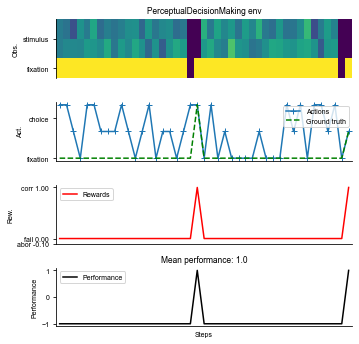

In [23]:
import neurogym as ngym

# Canned environment from neurogym
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset, neurogym boilerplate
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

For supervised learning, the task returns input and target output

In [25]:
# Generate one batch of data
inputs, target = dataset()
print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch, Dim) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = (100, 16, 3)
Target has shape (SeqLen, Batch, Dim) = (100, 16)


For reinforcement learning, the task returns observation and reward

In [ ]:
pass

### Training the network to perform the task

In [6]:
import torch.optim as optim

# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net):
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    # Loop over training batches
    for i in range(1000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
            running_loss = 0
    return net

net = train_model(net)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.0802
Step 200, Loss 0.0226
Step 300, Loss 0.0177
Step 400, Loss 0.0132
Step 500, Loss 0.0132
Step 600, Loss 0.0125
Step 700, Loss 0.0112
Step 800, Loss 0.0122
Step 900, Loss 0.0115
Step 1000, Loss 0.0111


### Run the network after training, record activity, computer performance

In [10]:
import numpy as np
# Reset environment
env.reset(no_step=True)

# Initialize variables
perf = 0
num_trial = 100
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

for i in range(num_trial):
    # Sample a new trial
    env.new_trial()
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    
    # Run the network for one trial
    # action_pred (SeqLen, Batch, OutputDim)
    action_pred, rnn_activity = net(inputs)
    
    # Compute performance
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]
    
    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial.copy()
    trial_infos[i].update({'correct': correct, 'choice': choice})
    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

# Print informations for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])
    
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Shape of the neural activity: (Time points, Neurons):  (2200, 64)
Trial  0 {'ground_truth': 1, 'coh': 12.8, 'correct': True, 'choice': 2}
Trial  1 {'ground_truth': 1, 'coh': 6.4, 'correct': True, 'choice': 2}
Trial  2 {'ground_truth': 0, 'coh': 6.4, 'correct': True, 'choice': 1}
Trial  3 {'ground_truth': 0, 'coh': 51.2, 'correct': True, 'choice': 1}
Trial  4 {'ground_truth': 1, 'coh': 25.6, 'correct': True, 'choice': 2}
Average performance 0.87


### Plot the network's activity in PCA

In [11]:
# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

PCA(n_components=2)

Text(0, 0.5, 'PC 2')

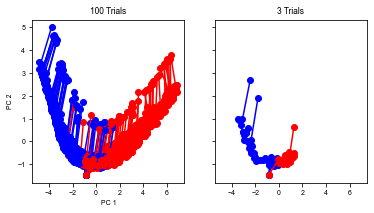

In [26]:
# Project each trial and visualize activity

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_title('{:d} Trials'.format(num_trial))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

### Exercise 1: Time constant of RNNs

**Easy** | Medium | Hard

Changing the time constant of network units from 100ms to 10ms, and re-train the network. How does the final performance change?

### Exercise 2: Plot the performance of RNN during training

**Easy** | Medium | Hard

Plot the performance of the task during the training process. Generate a plot with x-axis training steps, and y-axis performance.

### Exercise 3: Change the initialization of the RNN

**Easy** | Medium | Hard

Right now the RNN is initialized with the default pytorch initialization. Set instead the initial weight to an identity matrix. How does that influence the final performance?

### Exercise 4: Hierarchical RNNs

Easy | **Medium** | Hard

Make a hierarhical RNN, where the first module receives external input, the second module receives inputs from the first and project to the third module. The third module produces the outputs.

Train this hierarhical RNN on the task.

(Optional) Visualize the activity on each module.

### Exercise 5: Sequential training of tasks

Easy | **Medium** | Hard

First train the network on one task, then train the network on the second task. Plot the performance of both tasks during the training process.

Hint: you can get many tasks with the same input and output format using the yang19 collection in neurogym. Get the name of all tasks by running:

`print(ngym.get_collection('yang19'))`

### Exercise 6: Training only output connections

Easy | **Medium** | Hard

Train only the output connections of the network, and plot performance. Compare performance with gradient-descent trained networks.

### Exercise 7: Training spatially embedded RNNs

Easy | Medium | **Hard**

In normal neural networks, RNN units have no spatial locations. Assume that the RNN units are embedded in a 2-D cortical sheet, and it is more costly to have long-range connections. Train such spatially embedded RNNs and show that this influences the connectivity structure after training.

### Exercise 8: ConvNet + RNN

Easy | Medium | **Hard**

Add a convolutional network as the sensory module. Use a task that provides image input at each time point. No need to train the convolutional network.

Hint: Some tasks in neurogym provide image input at each time step. But you can generate your own task as well.

### Exercise 9: Short-term plasticity in RNN

Easy | Medium | **Hard**

Implement short-term plasticity in RNN and train the network on a working memory task. Compare the PCA trajectory with or without short-term plasticity.

Refer to Masse et al. 19 for details on the short-term plasticity.

TODO: Provide more detail